In [1]:
import pandas as pd
import subprocess
from Bio import Entrez, SeqIO
import ast
import os
import numpy as np
from collections import defaultdict
import time

In [11]:
## load chimeras found in > 1 genome
dfc=pd.read_csv("SI tables/SI table 4.tsv",sep="\t",index_col='cluster_id')
dfc=dfc[dfc.n_species>1]


## gene/CDS-wide dN/dS analysis

In [5]:

"""


Look up the gene accession (locus tag) linked to an NCBI protein accession
using E-utilities.  Requires: requests  (pip install requests)

"""

import sys
from pathlib import Path
from urllib.parse import urlencode
import xml.etree.ElementTree as ET
import requests


EUTILS_BASE = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"


def protein_to_gene(prot_acc,email):
    """Return the gene locus tag (or GeneID) linked to a protein accession."""
    # Step 1: elink -- protein → gene
    params = {
        "dbfrom": "protein",
        "db": "gene",
        "linkname": "protein_gene",
        "id": prot_acc,
        "retmode": "xml",
    }
    params["email"] = email

    r = requests.get(EUTILS_BASE + "elink.fcgi", params=params, timeout=10)
    r.raise_for_status()

    root = ET.fromstring(r.text)
    gene_ids = [elem.text for elem in root.findall(".//Link/Id")]
    if not gene_ids:
        return None

    # Step 2: efetch gene record (take first ID if multiple)
    gene_id = gene_ids[0]
    params = {"db": "gene", "id": gene_id, "retmode": "xml"}
    params["email"] = email

    r = requests.get(EUTILS_BASE + "efetch.fcgi", params=params, timeout=10)
    r.raise_for_status()

    root = ET.fromstring(r.text)
    locus = root.findtext(".//Gene-ref_locus")
    return locus or gene_id


EUTILS = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"

def protein_to_locus_tag(acc, email):
    """Fetch the GenBank record for *acc* and return its first /locus_tag."""
    params = {"db": "protein", "id": acc, "rettype": "gb", "retmode": "text"}
    if email:
        params["email"] = email

    r = requests.get(EUTILS + "efetch.fcgi", params=params, timeout=10)
    r.raise_for_status()

    for line in r.text.splitlines():
       
        # GenBank flat files indent qualifiers at column 21
        if " /locus_tag=" in line:
            return line.split("=", 1)[1].strip().strip('"')

    return None  



In [ ]:
for c in dfc.index:
    if c not in os.listdir("dnds") :

        main_directory =f"dnds/{c}"
        print(c)
        ## create a dictionary between genes/locus-ids and their protein isoforms 
        email1="rkapoor@g.harvard.edu"
        email2="rishabh.kapoorrk@gmail.com"
        td=set([x for x in ast.literal_eval(dfc.loc[c,'all_chimera_sequences'])])
        gene_to_isoform=defaultdict(list)
        i=0
        for xg in td:
            genome=xg.split(";")[0]
            x=xg.split(";")[1]
            if i%2==0:
                e=email1
            else:
                e=email2
            if 'P_' in x:
                g=protein_to_gene(x,e)
            else:
                g=protein_to_locus_tag(x,e)
            if x=='XP_029735553.1':
                gene_to_isoform[genome+"_"+"LOC109414258"].append(x)
            else:
                gene_to_isoform[genome+"_"+g].append(x)
            time.sleep(2)
            i+=1
        
        ##select a single protein isoform/gene
        select_isos=[]
        for gene,isos in gene_to_isoform.items():
            if dfc.loc[c,'q_name'].split(";")[1] in isos:
                select_isos.append(dfc.loc[c,'q_name'].split(";")[1])
            else:
                select_isos.append(isos[0])
        
        subprocess.run(["mkdir", "-p", f"dnds/{c}"])
        #download protein and nucleotide fastas 
        sec_chimeras=[x.split(";")[1] for x in ast.literal_eval(dfc.loc[c,:].all_chimera_sequences)]
        for acc in select_isos:
            subprocess.run(["mkdir", f"dnds/{c}/{acc}"])
            url_na=f"http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={acc}&rettype=fasta_cds_na" 
            url_prot=f"http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={acc}&rettype=fasta" 
            subprocess.run(["wget",url_na,"-O",f"dnds/{c}/{acc}/nuc.fasta"])
            subprocess.run(["wget",url_prot,"-O",f"dnds/{c}/{acc}/prot.fasta"])
            time.sleep(5)
        Create an output file for concatenated sequences
        output_nuc = f"dnds/{c}/concatenated_nuc.fasta"
        output_prot = f"dnds/{c}/concatenated_prot.fasta"

        # Initialize an empty list to store sequences
        all_nucs = []
        all_prots = []

        # Iterate through subdirectories and create a list of all fastas
        #Written by RK w/ ChatGPT
        for subdir in os.listdir(main_directory):
            subdirectory_path = os.path.join(main_directory, subdir)

            if os.path.isdir(subdirectory_path):
                nuc_fasta_file = os.path.join(subdirectory_path, "nuc.fasta")
                prot_fasta_file = os.path.join(subdirectory_path, "prot.fasta")
                if os.path.exists(nuc_fasta_file):
                    # Read the sequences from nuc.fasta and add to the list
                    sequences = list(SeqIO.parse(nuc_fasta_file, "fasta"))
                    all_nucs.extend(sequences)

                if os.path.exists(prot_fasta_file):
                    # Read the sequences from nuc.fasta and add to the list
                    sequences = list(SeqIO.parse(prot_fasta_file, "fasta"))
                    all_prots.extend(sequences)

        # Write the concatenated sequences to the output file
        with open(output_nuc, "w") as output_handle:
            SeqIO.write(all_nucs, output_handle, "fasta")

        with open(output_prot, "w") as output_handle:
            SeqIO.write(all_prots, output_handle, "fasta")
        
        
        input_file = open(f"dnds/{c}/concatenated_prot.fasta")
        prot_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        input_file = open(f"dnds/{c}/concatenated_nuc.fasta")
        nuc_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        
        f=open(f"dnds/{c}/concatenated_nuc.fasta","w")
        f1=open(f"dnds/{c}/concatenated_prot.fasta","w")
        for p in prot_dict.keys():
            kn=[x for x in nuc_dict.keys() if p in x]
            if len(kn)>0:
                kn=kn[0]
                f.write(f">{kn}")
                f.write("\n")
                f.write(str(nuc_dict[kn].seq))
                f.write("\n")

                f1.write(f">{p}")
                f1.write("\n")
                f1.write(str(prot_dict[p].seq))
                f1.write("\n")
        f.close()
        f1.close()
        ## make a fake tree if only two sequences
        if len(prot_dict)==2:
            print("Concatenation complete.")
            f=open(f"dnds/{c}/tree.newick","w")
            f.write("(")
            f.write(str(all_prots[0].name))
            f.write(":1,")
            f.write(str(all_prots[1].name))
            f.write(":1")
            f.write(");")
            f.close()
            subprocess.run(["sh","dnds_scripts/run_muscle.sh", "dnds/"+str(c)])
        ##else 
        else:
            subprocess.run(["sbatch","dnds_scripts/run_iqtree_dnds_pipe.sh", "dnds/"+str(c)])

            
  
   
 



Submitted batch job 26147058
Submitted batch job 26147106
Submitted batch job 26147121
Submitted batch job 26147135
Submitted batch job 26147170
Submitted batch job 26147195
Submitted batch job 26147580
Submitted batch job 26148216


In [9]:
## get codon alignment
for c in dfc.index:
    if "paml_output.out" not in os.listdir(f"dnds/{c}"):
        print(c,dfc.loc[c,"n_species"])
        input_file = open(f"dnds/{c}/MSA_concatenated_prot.fasta")
        prot_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        input_file = open(f"dnds/{c}/concatenated_nuc.fasta")
        nuc_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        #make sure msa and nucleotide fasta are in the same order 
        f=open(f"dnds/{c}/concatenated_nuc.fasta","w")
        f1=open(f"dnds/{c}/MSA_concatenated_prot.fasta","w")
        for p in prot_dict.keys():
            kn=[x for x in nuc_dict.keys() if p in x]
            if len(kn)>0:
                kn=kn[0]
                f.write(f">{kn}")
                f.write("\n")
                f.write(str(nuc_dict[kn].seq))
                f.write("\n")

                f1.write(f">{p}")
                f1.write("\n")
                f1.write(str(prot_dict[p].seq))
                f1.write("\n")
        f.close()
        f1.close()
        #produce a gapless codon alignment guided by the MSA 
        subprocess.run(["sh","dnds_scripts/run_pal2nal.sh", "dnds",str(c)])

23 2


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


21 2


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


20 2


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


19 2


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


18 2


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


17 2


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


16 2


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


15 2


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


14 2


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


22 2


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


13 3


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


12 3


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


10 3


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


9 3


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


11 3


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


8 4


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


7 4


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


6 5


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


5 7


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


4 9


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


3 11


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


2 11


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


1 181


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


In [ ]:
## run paml to fit a gene-wide dnds estimate
for c in dfc.sort_values("n_species").index:
    subprocess.run(["sbatch","dnds_scripts/run_paml_m0.sh", str(c)])

In [35]:
## run paml on the null model (dnds=1)
for c in dfc.sort_values("n_species").index:
    subprocess.run(["sbatch","dnds_scripts/run_fixed_paml_whole_gene.sh", str(c)])

Submitted batch job 26211451
Submitted batch job 26211463
Submitted batch job 26211485
Submitted batch job 26211489
Submitted batch job 26211491
Submitted batch job 26211521
Submitted batch job 26211524
Submitted batch job 26211545
Submitted batch job 26211549
Submitted batch job 26211585
Submitted batch job 26211589
Submitted batch job 26211600
Submitted batch job 26211610
Submitted batch job 26211640
Submitted batch job 26211648
Submitted batch job 26211660
Submitted batch job 26211669
Submitted batch job 26211685
Submitted batch job 26211691
Submitted batch job 26211697
Submitted batch job 26211699
Submitted batch job 26211703
Submitted batch job 26211705


In [9]:
##compile a table with the results
import pandas as pd
dnds_data=pd.DataFrame(index=dfc[dfc.n_species>1].sort_values("n_species").index, columns=["dnds_f","lnL_f","np_f","dS_f","lnL_1","np_1"]) 

In [3]:
import numpy as np
import scipy 
from scipy import stats
from statsmodels.stats.multitest import multipletests

/n/home11/rkapoor/.conda/envs/rishabh/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [28]:
gene_dnds={}
fails=[]
for c in dfc[dfc.n_species>1].sort_values("n_species").index:
    
    
    if "paml_output.out" in os.listdir(f"dnds/{c}") and "tree.newick" in os.listdir(f"dnds/{c}"):
       
        f=open(f"dnds/{c}/paml_output.out","r").readlines()
        t=False
        for i  in range(len(f)):
            x=f[i]
            if "omega (dN/dS) =" in x:
                dnds_data.loc[c,"dnds_f"]=ast.literal_eval(x.split("omega (dN/dS) =")[1].strip())
                
                t=True
            if "lnL(" in x:
                dnds_data.loc[c,"np_f"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
                dnds_data.loc[c,"lnL_f"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
            if "tree length for dS:" in x:
                dnds_data.loc[c,"dS_f"]=ast.literal_eval(x.split("tree length for dS:")[1].strip().split()[0])
            if "Printing out site pattern counts" in x:
            
                dnds_data.loc[c,"n_codons"]=ast.literal_eval(f[i+3].split()[1])/3
        if t==False:
            fails.append(c)
    else:
        print("no_paml"+c)
        fails.append(c)
       

In [29]:
for c in dfc[dfc.n_species>1].sort_values("n_species").index:
    
    
    if "fix_omega_paml_output.out" in os.listdir(f"dnds/{c}") and "tree.newick" in os.listdir(f"dnds/{c}"):
       
        f=open(f"dnds/{c}/fix_omega_paml_output.out","r").readlines()
        t=False
        for x in f:
           
            if "lnL(" in x:
                dnds_data.loc[c,"np_1"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
                dnds_data.loc[c,"lnL_1"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
            
        if t==False:
            fails.append(c)
    else:
        print("no_paml"+c)
        fails.append(c)
       

In [30]:
dnds_data["delta_p"]=np.array(dnds_data["np_f"])-np.array(dnds_data["np_1"])
dnds_data["2*delta_L"]=2*(np.array(dnds_data["lnL_f"])-np.array(dnds_data["lnL_1"]))
# rum likelihood ratio test comparing dnds to dnds fixed at 1 
for index, row in dnds_data.iterrows():
    dnds_data.loc[index,"p_val"]=scipy.stats.chi2.sf(row["2*delta_L"],row["delta_p"])

In [31]:


# Example p-values
p_values = dnds_data.p_val

# Perform Benjamini-Hochberg correction
corrected_p_values =list( multipletests(p_values, method='fdr_bh')[1])

dnds_data.loc[:,"p_val_corrected"]=corrected_p_values

In [35]:
for index, row in dnds_data.iterrows():
    dnds_data.loc[index,'protein']=dfc.loc[int(index),'q_name'].split(";")[1]

In [37]:
dnds_data.to_csv("SI tables/gene_wide_dnds.csv")

## Run a partition model to obtain separate dn/ds estimates for HGT intervals

In [49]:
file=open("partion_model_fail.txt","w")
for c in dfc.index:
    if "tree.newick" in os.listdir(f"dnds/{c}"):
        try:
            ##run pal2nal to get a codon alignment with both amino acids and codons (including gaps)
            subprocess.run(["sh","dnds_scripts/run_pal2nal_codon.sh", str(c)])
            lines=open(f"dnds/{c}/pal2nal.codon","r").readlines()

            lines=[x.replace("\n","") for x in lines]
      
            nuc_al={}
            for i in range(len(lines)-1):
                l=lines[i].split()
                if len(l)>1:
                    ##select nucleotide lines of codon alignment, which begin with the name
                    if len(l[0])>3:

                        key=l[0]
                        if key not in nuc_al:
                            nuc_al[key]=l[1:]
                        else:
                            tl=nuc_al[key]
                            tl.extend(l[1:])
                            nuc_al[key]=tl
            ##produce a list of indices in the gapless alignment from the residue position in the representative chimera
            pos_ch=[]
            ch_index=0
            chimera=dfc.loc[c,'q_name'].split(";")[1]
            for i in range(len(nuc_al[chimera])):
                if nuc_al[chimera][i]!='---':
                    ch_index+=1
                if len([gene for gene in nuc_al.keys() if nuc_al[gene][i]=="---" or nuc_al[gene][i]=="TAA" or nuc_al[gene][i]=="TAG" or nuc_al[gene][i]=="TGA"])==0:
                    pos_ch.append(ch_index)

            inters=ast.literal_eval(dfc.loc[c,'HGT_intervals'])     
            #write a paml configuration with residues in the hgt interval(s) marked as site type '2'
            #other residues marked as site type '1'
            for interi in inters:
                inter=str(interi).replace(" ","")
                if inter not in os.listdir(f"dnds/{c}"):
                    print(inter)
                    try:
                        subprocess.run(["rm","-r",f"dnds/{c}/{inter}"])
                    except:
                        p=1
                    try:
                        os.mkdir(f"dnds/{c}/{inter}")
                    except:
                        p=1
                    
                 
                    f=open(f"dnds/{c}/pal2nal.paml","r").readlines()
                    f1=open(f"dnds/{c}/{inter}/fs_pal2nal.paml","w")
                    f[0].replace("\n","G \n")
                    f1.write(f[0].replace("\n","G \n"))
                    f1.write("G2")
                    f1.write("\n")
                    flags=[str(int(x>=interi[0] and x<=interi[1])+1) for x in pos_ch]
                    f1.write("".join(flags))
                    f1.write("\n")
                    for x in f[1:]:
                        f1.write(x)
                    f1.close()
                    subprocess.run(["sbatch","dnds_scripts/run_partition_paml.sh",str(c),str(inter)])
        except:
            file.write(c)
            file.write("\n")
 
file.close()

perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


(352,559)
Submitted batch job 26344851


rm: cannot remove 'dnds/2/(352,559)': No such file or directory
perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


(127,249)
Submitted batch job 26344856


rm: cannot remove 'dnds/3/(127,249)': No such file or directory
perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/6/(450,633)': No such file or directory


(450,633)
Submitted batch job 26344858


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


(4,113)
Submitted batch job 26344859


rm: cannot remove 'dnds/7/(4,113)': No such file or directory
perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


(48,253)


rm: cannot remove 'dnds/8/(48,253)': No such file or directory


Submitted batch job 26344861


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/9/(5,150)': No such file or directory


(5,150)
Submitted batch job 26344862
(385,523)
Submitted batch job 26344863
(190,334)


rm: cannot remove 'dnds/9/(385,523)': No such file or directory
rm: cannot remove 'dnds/9/(190,334)': No such file or directory


Submitted batch job 26344864


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


(31,318)
Submitted batch job 26344865


rm: cannot remove 'dnds/10/(31,318)': No such file or directory
perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").


(250,350)
Submitted batch job 26344867


rm: cannot remove 'dnds/11/(250,350)': No such file or directory
perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/12/(736,1165)': No such file or directory


(736,1165)
Submitted batch job 26344869


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/13/(49,487)': No such file or directory


(49,487)
Submitted batch job 26344870


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/14/(88,215)': No such file or directory


(88,215)
Submitted batch job 26344871


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/15/(720,878)': No such file or directory


(720,878)
Submitted batch job 26344872


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/16/(6,216)': No such file or directory


(6,216)
Submitted batch job 26344873


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/17/(482,1243)': No such file or directory


(482,1243)
Submitted batch job 26344874


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/18/(394,509)': No such file or directory


(394,509)
Submitted batch job 26344875


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/19/(312,439)': No such file or directory


(312,439)
Submitted batch job 26344876


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/20/(749,869)': No such file or directory


(749,869)
Submitted batch job 26344877


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/21/(278,504)': No such file or directory


(278,504)
Submitted batch job 26344878


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/22/(215,442)': No such file or directory


(215,442)
Submitted batch job 26344879


perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = "en_US.UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
rm: cannot remove 'dnds/23/(222,383)': No such file or directory


(222,383)
Submitted batch job 26344880


In [12]:
pdnds=pd.DataFrame()
import ast
for c in dfc.index:
    inters=ast.literal_eval(dfc.loc[c,'HGT_intervals'])     
    for inter in inters:
        inter=str(inter).replace(" ","")
        try:
            lines=open(f"dnds/{c}/{inter}/fs_pal2nal.paml", "r").readlines()
            pdnds.loc[f"{c}_{inter}","nsites_2"]=len([x for x in lines[2].strip() if x=='2'])
            pdnds.loc[f"{c}_{inter}","nsites"]=len(lines[2].strip())
        except:
            p=1
        try:
            lines=open(f"dnds/{c}/{inter}/m2_paml_output.out", "r").readlines()
            for x in lines:
                if "omega (dN/dS) =" in x:
                    pdnds.loc[f"{c}_{inter}","dnds_f"]=ast.literal_eval(x.split("omega (dN/dS) =")[1].strip())
                if "lnL(" in x:
                    pdnds.loc[f"{c}_{inter}","np_f"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
                    pdnds.loc[f"{c}_{inter}","lnL_f"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
        except:
            print(inter)
            
        try:
            lines=open(f"dnds/{c}/{inter}/m4_paml_output.out", "r").readlines()
            for x in lines:
                if "gene # 1: kappa =" in x:
                    pdnds.loc[f"{c}_{inter}","dnds_1"]=ast.literal_eval(x.split("omega =")[1].strip())
                if "gene # 2: kappa =" in x:
                    pdnds.loc[f"{c}_{inter}","dnds_2"]=ast.literal_eval(x.split("omega =")[1].strip())
                if "lnL(" in x:
                    pdnds.loc[f"{c}_{inter}","np_p"]=ast.literal_eval(x.split("lnL(")[1].split("np:")[1].split(")")[0].strip())
                    pdnds.loc[f"{c}_{inter}","lnL_p"]=ast.literal_eval(x.split("):")[1].strip().split()[0])
                
        except:
            print(inter)

In [13]:
pdnds["delta_p"]=np.array(pdnds["np_p"])-np.array(pdnds["np_f"])
pdnds["2*delta_L"]=2*(np.array(pdnds["lnL_p"])-np.array(pdnds["lnL_f"]))
for index, row in pdnds.iterrows():
    pdnds.loc[index,"p_val"]=scipy.stats.chi2.sf(row["2*delta_L"],row["delta_p"])
p_values = pdnds.p_val

# Perform Benjamini-Hochberg correction
corrected_p_values = multipletests(p_values, method='fdr_bh')[1]

correct_p_values=list(corrected_p_values)
pdnds.loc[:,"correct_p_values"]=correct_p_values

In [17]:
for index, row in pdnds.iterrows():
    pdnds.loc[index,'protein']=dfc.loc[int(index.split("_")[0]),'q_name']

In [18]:
pdnds.shape[0]

25

In [34]:
pdnds.to_csv("SI tables/partition_dnds_results.csv")

## Plot and summarize data

In [20]:
dnds_data=pd.read_csv("SI tables/gene_wide_dnds.csv",index_col=0)

In [19]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt

import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fpath = Path(mpl.get_data_path(), "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
plt.rcParams['figure.dpi'] = 300
font_path = "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf"
font_manager.fontManager.addfont("/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['svg.fonttype']='none'

In [13]:
dnds=dnds[~dnds.index.isin([3,18])]

In [23]:
dnds.shape[0]

21

In [33]:
pdnds['cluster']=[x.split("_")[0] for x in pdnds.index]
pdnds=pdnds[~pdnds['cluster'].isin(['3','18'])]
pdnds['hgt_interval_coordinates']=[x.split("_")[1] for x in pdnds.index]
pdnds['hgt_interval_start']=[x.split(",")[0].replace("(","") for x in pdnds.hgt_interval_coordinates]
pdnds['hgt_interval_end']=[x.split(",")[1].replace(")","") for x in pdnds.hgt_interval_coordinates]


In [22]:
len(set(pdnds.c))

21

In [23]:
pdnds.shape[0]

23

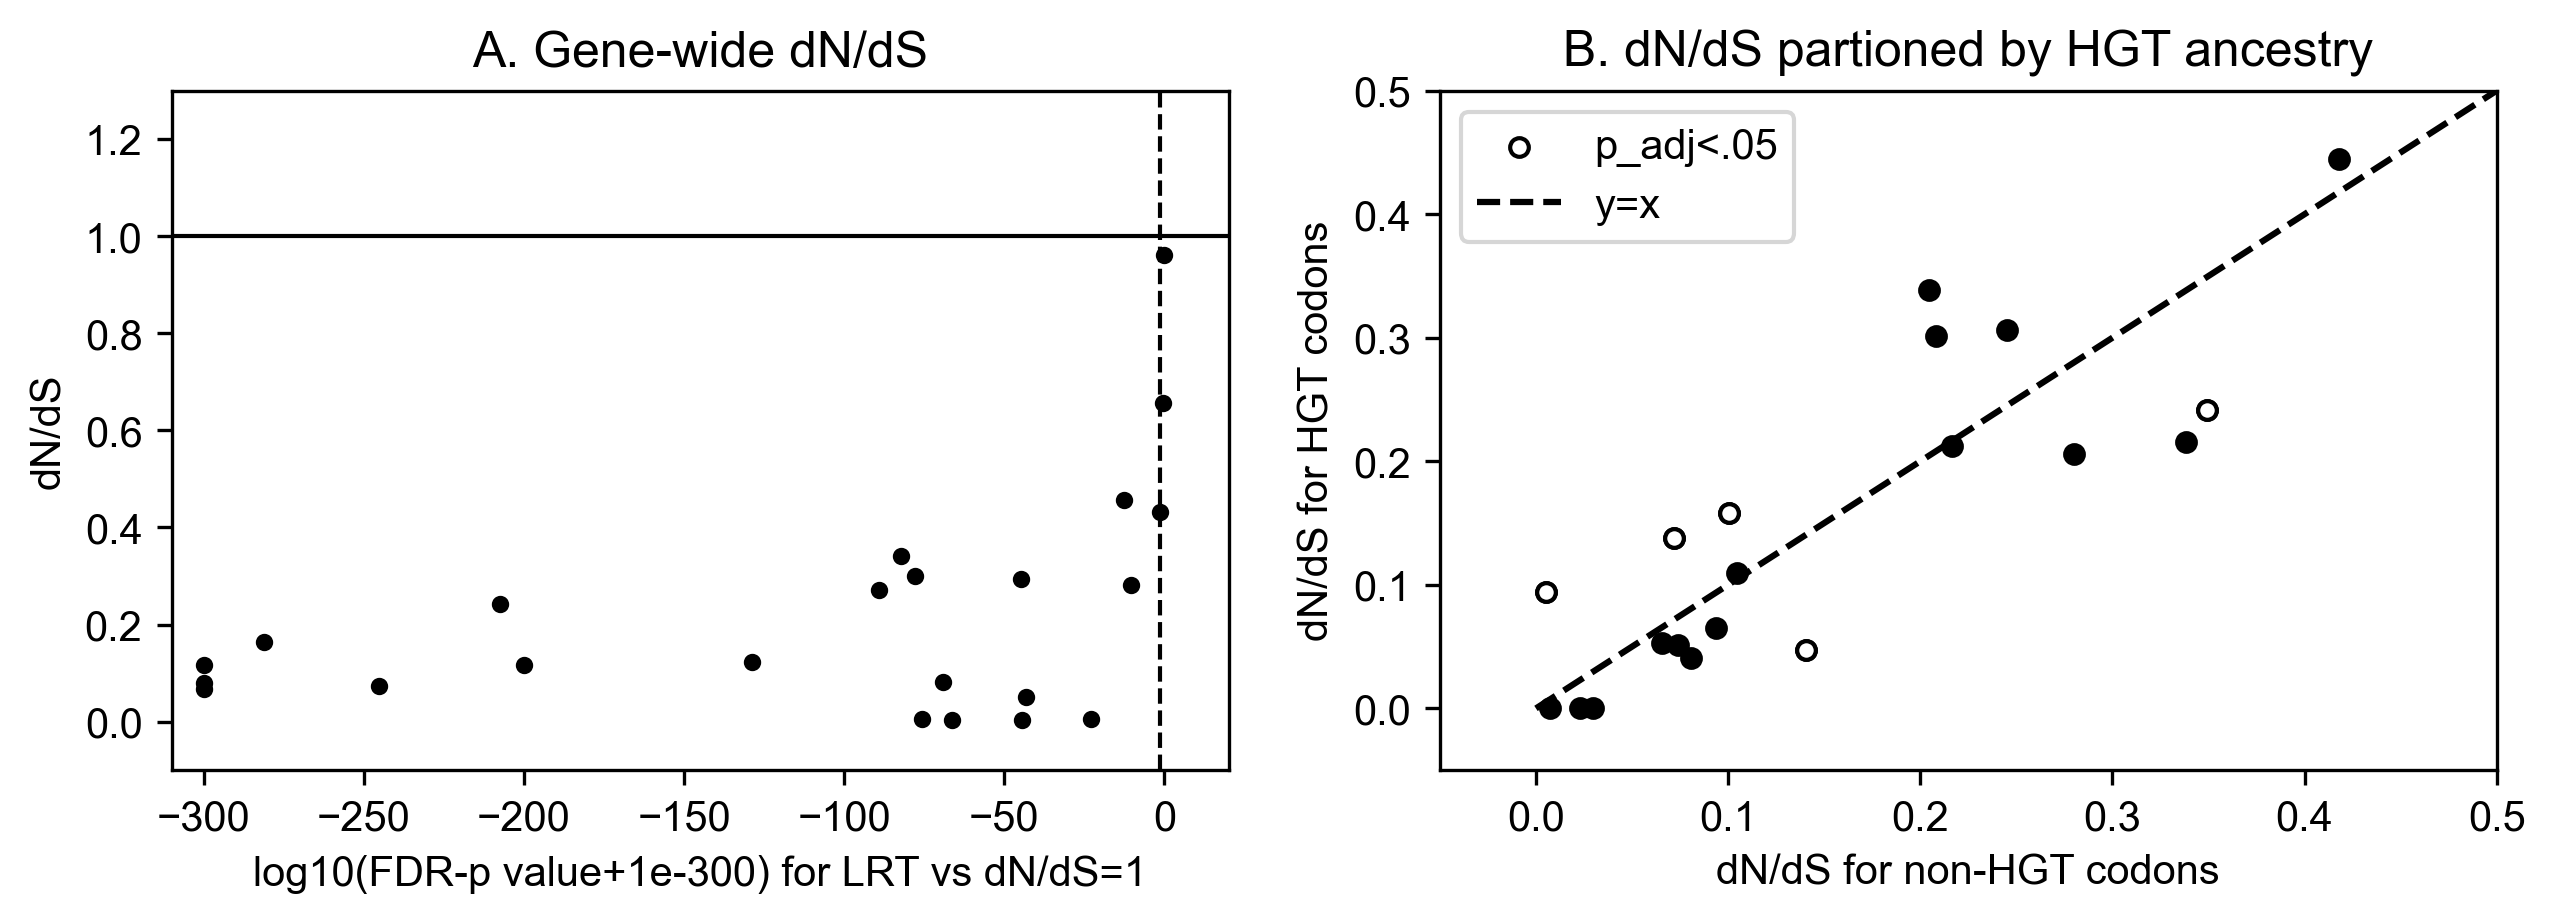

In [21]:
fig,ax=plt.subplots(1,2,dpi=300,figsize=(10,3))
ax[0].scatter(np.log10(dnds_data.p_val_corrected+1e-300),dnds_data.dnds_f,s=10,color='black')
ax[0].vlines(np.log10(.05),-.1,1.5,color='black',linestyle='dashed',label="p_adj=.05",linewidth=1)
ax[0].hlines(1,-320,20,color='black',linewidth=1)
ax[0].set_ylim(-.1,1.3)
ax[0].set_xlim(-310,20)
ax[0].set_title("A. Gene-wide dN/dS" )
ax[0].set_ylabel("dN/dS")
ax[0].set_xlabel("log10(FDR-p value+1e-300) for LRT vs dN/dS=1")


ax[1].scatter(pdnds.dnds_1,pdnds.dnds_2,color='black',s=20)
ax[1].scatter(pdnds[pdnds.correct_p_values < .05].dnds_1,
            pdnds[pdnds.correct_p_values < .05].dnds_2,
            color='white',
            edgecolor='black',  # Add black outline to points
            label="p_adj<.05",
            s=20)
ax[1].plot(np.linspace(0,.8,10),np.linspace(0,.8,10),label="y=x",color='black',linestyle='dashed')
ax[1].set_xlim(-0.05,.5)
ax[1].set_ylim(-.05,.5)
ax[1].legend()
ax[1].set_xlabel("dN/dS for non-HGT codons")
ax[1].set_ylabel("dN/dS for HGT codons")
ax[1].set_title("B. dN/dS partioned by HGT ancestry")


plt.savefig("figures/combined_partition_dnds.svg",format='svg')
plt.show()

In [111]:
dnds.shape[0]

21

In [114]:
dnds[dnds.dnds_f<1].shape[0]

21

In [115]:
dnds[dnds.p_val_corrected<.05].shape[0]

19

In [112]:
dnds[dnds.p_val_corrected<.05].shape[0]

19

In [120]:
pdnds.shape[0]

23

In [119]:
pdnds[pdnds.dnds_2>pdnds.dnds_1].shape[0]

11

In [123]:
len(set(pdnds.prot))

21

In [126]:
pdnds[(pdnds.dnds_2>pdnds.dnds_1)&(pdnds.correct_p_values<.05)].shape[0]

3